In [114]:
# Synapse Classification Challenge
# Introduction to Connectomics 2017
# J. Wu (your name here)

your_name = 'Wu_Jenny'
!pip install mahotas
!pip install ndparse
%matplotlib inline

In [115]:
# Load data

import numpy as np

data = np.load('./synchallenge2017_training.npz')

imtrain = data['imtrain']
annotrain = data['annotrain']
ytrain = data['ytrain']

data = np.load('./synchallenge2017_validation.npz')

imvalid = data['imvalid']
annovalid = data['annovalid']
yvalid = data['yvalid']

In [116]:
# Define feature extraction code

import skimage.feature as skif

def extract_features(imdata):
    xtrain = []
    for im in imdata:
        fvector = []
        # all pixels' intensity
        #for row in im: 
           #for intensity in row:
                #fvector.append(intensity)
        
        #50th percentile based on intensity
        fvector.append(np.percentile(im,30))
    
        # count the number of edges feature
        edgeim = skif.canny(im, sigma=1.0, low_threshold=0.1, high_threshold=0.4, mask=None, use_quantiles=True)
        edgecount = 0
        for something in edgeim:
            for edge in something:
                if edge == 1:
                    edgecount += 1
        fvector.append(edgecount)
        
        # calculate the hessian matrix
        hessmatrix = skif.hessian_matrix(im)
        hessmatrix = np.ravel(hessmatrix)
        for value in hessmatrix:
            fvector.append(value)
        
        # add a contrast feature
        g = skif.greycomatrix(im, [1, 2], [0, np.pi/2],normed=True, symmetric=True)
        energy = skif.greycoprops(g, 'energy')

        # explict way to add feature elements one at a time
        energy = np.ravel(energy)
        for i in energy:
            fvector.append(i)

        fvector = np.asarray(fvector)
        xtrain.append(fvector)

    return np.asarray(xtrain)
    

In [117]:
# Extract Features from training

xtrain = extract_features(imtrain)
# Train Classifier

from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=200)
clf = clf.fit(xtrain, ytrain)

# Feature Importance
from sklearn import datasets
from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier
# load the iris datasets
dataset = datasets.load_iris()
# fit an Extra Trees model to the data
model = ExtraTreesClassifier()
model.fit(dataset.data, dataset.target)
# display the relative importance of each attribute
print(model.feature_importances_)


[ 0.07584487  0.04459804  0.40695322  0.47260387]


In [118]:
# Extract features from validation set
xvalid = extract_features(imvalid)


In [119]:
# Run Classifier on validation set
scoresvalid = clf.predict_proba(xvalid)

In [120]:
# Best f1 score report on validation set

from sklearn.metrics import f1_score

# Can add post-processing here if desired

prob_syn = scoresvalid[:,1]

# default threshold
print('default f1 score: {}'.format(np.round(f1_score(yvalid, prob_syn >=0.5),6)))

f1_out = 0
thresh = 0
for i in np.arange(0.0, 1, 0.05):
    f1_test =  f1_score(yvalid, prob_syn > i)
    if f1_test > f1_out:
        f1_out = f1_test
        thresh = i

print('My best validation f1-score is: {} at {} threshold.'.format(np.round(f1_out,6), thresh))

default f1 score: 0.832208
My best validation f1-score is: 0.829892 at 0.5 threshold.


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


synapse present - true positive


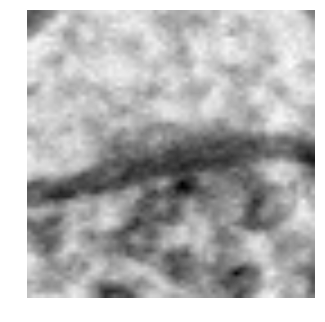

no synapse present - true negative


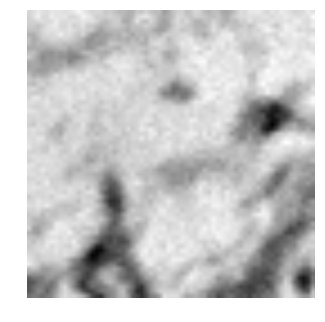

synapse present - false negative


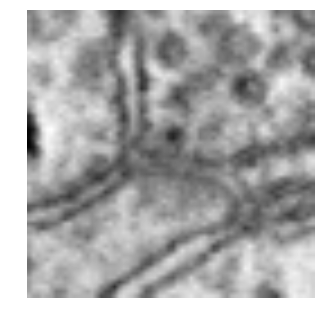

no synapse present - false positive


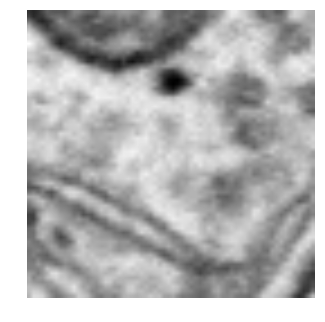

In [121]:
# here we can inspect results

valid_labels = np.asarray(prob_syn > thresh,dtype='int')
# find images we did well on
idx_correct_syn = np.where((valid_labels == yvalid) & (yvalid == 1))[0]
idx_correct_nosyn = np.where((valid_labels == yvalid) & (yvalid == 0))[0]
# find images we did poorly on

idx_wrong_syn = np.where((valid_labels != yvalid) & (yvalid == 1))[0]
idx_wrong_nosyn = np.where((valid_labels != yvalid) & (yvalid == 0))[0]
import ndparse as ndp

print('synapse present - true positive')
ndp.plot(imvalid[idx_correct_syn[3]])

print('no synapse present - true negative')
ndp.plot(imvalid[idx_correct_nosyn[3]])

print('synapse present - false negative')
ndp.plot(imvalid[idx_wrong_syn[3]])

print('no synapse present - false positive')
ndp.plot(imvalid[idx_wrong_nosyn[3]])

In [122]:
# Validate performance on test set (should only run/score once!)

data = np.load('./synchallenge2017_test_notruth.npz')

imtest = data['imtest']
annotest = data['annotest']

# Extract features from test set
xtest = extract_features(imtest)

# Run classifier on test set
scoretest = clf.predict_proba(xvalid)

# Post-processing
prob_syntest = scoretest[:,1]
syntest_predict = prob_syntest > thresh
syntest_predict = np.asarray(syntest_predict,dtype = 'uint8')

# save file and upload to google docs with label vector
np.save(your_name+'_synchallenge_testdata.npy',syntest_predict)